In [1]:
import sys
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Dropout
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, concatenate
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from attention import AttentionLayer #ok
import pprint


''' 5 有词干化 不<NUM> summary与description分开词汇表
all 6108 37885
httpclient 1377 7958
jackrabbit 3038 17291
lucene 3376 18496
'''

' 5 有词干化 不<NUM> summary与description分开词汇表\nall 6108 37885\nhttpclient 1377 7958\njackrabbit 3038 17291\nlucene 3376 18496\n'

In [2]:
#参数配置
class Config(object):

    #数据集路径
    project_name = "output5\\lucene"

    #训练参数
    num_hidden = 100
    num_layer = 3
    non_static = True

    summary_length = 6109
    description_length = 37886
    priority_length = 6
    n_epoch = 10
    batch_size = 32
    num_classes = 2
    dropoutKeepProb = 0.3

    #保存路径
    log_dir = 'LSTM_log\\all'
    model_dir = 'com_BiGRU_model\\BiGRU.h5'

In [3]:
def split_data(data):
    '''将数据中的句向量和标签取出'''
    s_data, d_data, p_data, l_data = [], [], [], []
    for d in data:
        s_data.append(d[1])
        d_data.append(d[2])
        p_data.append(d[3])
        l_data.append(d[4])
    s_data = np.asarray(s_data, dtype="int64")
    d_data = np.asarray(d_data, dtype="int64")
    p_data = np.asarray(p_data, dtype="int64")
    l_data = np.asarray(l_data, dtype="int64")
    return s_data, d_data, p_data, l_data

In [4]:
def load_data(config):
    '''加载训练、验证、测试数据'''
    print("load data")
    print("function : load data")
    print("type of batch_size : ", type(config.batch_size))
    train_data = pickle.load(open(config.project_name + "/train_nn.pkl", "rb"))
    valid_data = pickle.load(open(config.project_name + "/valid_nn.pkl", "rb"))
    test_data = pickle.load(open(config.project_name + "/test_nn.pkl", "rb"))
    print("train data :", len(train_data))
    print("valid data :", len(valid_data))
    print("test data :", len(test_data))
    return train_data, valid_data, test_data

In [5]:
def build_model(config):
    # '''构建模型'''
    print("build the model")
    #论文基本模型 函数式
    #summary
    input_summary = Input(shape=(50,), dtype='int64', name='summary')
    embedded_summary = Embedding(config.summary_length, 32)(input_summary)
    encode_summary = Bidirectional(GRU(16))(embedded_summary)

    #description
    input_description = Input(shape=(100,), dtype='int64', name='description')
    embedded_description = Embedding(config.description_length, 32)(input_description)
    encode_description = Bidirectional(GRU(16))(embedded_description)

    #priority
    input_priority = Input(shape=(1,), dtype='int64', name='priority')
    embedded_priority = Embedding(config.priority_length, 8)(input_priority)
    encode_priority = Flatten()(embedded_priority)
    #concat
    concatenated = concatenate([encode_summary, encode_description, encode_priority], axis=-1)
    den_1 = Dense(64, activation='relu')(concatenated)
    drop_1 = Dropout(config.dropoutKeepProb)(den_1)
    den_2 = Dense(64, activation='relu')(drop_1)
    drop_2 = Dropout(config.dropoutKeepProb)(den_2)
    output = Dense(1, activation='sigmoid')(drop_2)
    
    model = Model([input_summary, input_description, input_priority], output)

    rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

    model.compile(optimizer=rmsprop,  # adam rmsprop
                  loss='binary_crossentropy',  # mse binary_crossentropy
                  metrics=['acc']) #metrics=['acc', precision, recall, f1]
    model.summary()
    return model

In [6]:
def train(config):

    #定义回调函数
    callbacks_list = [
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3
        ),
        ModelCheckpoint(
            filepath=config.model_dir,
            monitor='val_loss',
            save_best_only=True
        ),
    ]



    history = model.fit([train_summary, train_description, train_priority], train_label,
                        epochs=config.n_epoch,
                        batch_size=config.batch_size,
                        callbacks=callbacks_list,
                        validation_data=([valid_summary, valid_description, valid_priority], valid_label))
    return history






In [7]:
def evaluate(config):
    #模型评估
    #模型评估
    model1 = load_model(config.model_dir)
    results = model1.evaluate([test_summary, test_description, test_priority], test_label)
    pprint.pprint(results)

In [8]:
def draw(history):
    #绘制结果
    history_dict = history.history
    print(history_dict)
    train_acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(train_acc) + 1)

    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss of Jackrabbit')
    plt.legend()
    plt.show()

    plt.plot(epochs, train_acc, 'go', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy of Jackrabbit')
    plt.legend()
    plt.show()

load data
function : load data
type of batch_size :  <class 'int'>
train data : 1978
valid data : 220
test data : 245
build the model
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
summary (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
description (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
priority (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 32)       195488

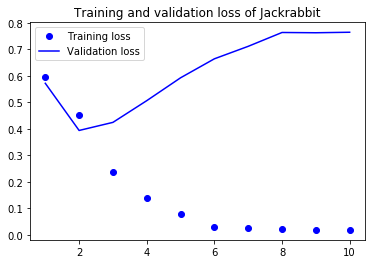

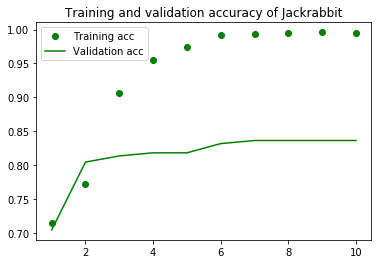

In [10]:
if __name__ == "__main__":
    config = Config()

    train_data, valid_data, test_data = load_data(config)
    '''分离数据中的句子和标签'''
    
    train_summary, train_description, train_priority, train_label = split_data(train_data)
    valid_summary, valid_description, valid_priority, valid_label = split_data(valid_data)
    test_summary, test_description, test_priority, test_label = split_data(test_data)

    model = build_model(config)
    
    history = train(config)
    
    evaluate(config)
    
    draw(history)